# QAOA MaxCut-Qiskit

In [125]:
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

from scipy.optimize import minimize

In [126]:
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq import least_busy# sterge daca nu folosesti
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import warnings
warnings.filterwarnings('ignore')

## MaxCut dilema:
   
   The Max cut dilema can be stated as follow:
    
      
   We have a undirected graph G with vertices divided in two subsets (R-red , B-blue). If an edge conects two vertices from different subsets than we say that that edge is cut. If each edge has an associated weight $ w_i$  how can we divide the vertices between the two sets such that the sum of cut weights will be maximum ?


$$ C = \sum_{l}w_{l}. $$ 
$$w_{l}-cut weight$$ 

  $$ C(\textbf{x}) =  \sum_{i,j;i<j} w_{ij} x_i (1-x_j) $$

   Where $ \textbf{x}=x_0..x_i..x_n $ is a string. of 0 and 1 and $x_i$ represents the color of the i-th vertice.

 ## Qbitization

Next step is to  upload the problem on QC one way to do that is to think that each vertice is a qubit. C can then be writen as a Hamiltonian :

$$H_c = \sum_{ij} \frac{w_{ij}}{4} (I-Z_iZ_j)$$

OBS: $H_c$ va avea valoarea maxima cand $H_C$ va avea valoarea iminima prin urmare daca rusim s agasim configuratia care minimizeaza $H_C$ am gasit configuratia care maximizeaza $H_c$

$ Z_i $ means Z on i-th qubit.  

$$ ZZ|00>=|00>,<00|ZZ|00>=<00|II|00>=1;$$
$$ ZZ|11>=|00>,<11|ZZ|11>=1;$$
$$ ZZ|10>=-|10>,<10|ZZ|10>=-1;$$
$$ ZZ|01>=-|00>,<01|ZZ|01>=-1.$$

If the qubits are in different states we will get -1 and (-1)(-1)=1 and 1 added with 1 given by I is 2, that's part of the reason for division with 4 the second 2 is coming from the fact that we count each weight two times. (now I eliminate "<"). 
Now we have the Hamiltonian whose minimum eiganvalue we want to find. $ \frac{1}{4}$ is a scalar so if we are only interested in the eigenvector that has a minimum eigenvalue associated we can omit this factor.

Dar sa nu ne grabim ! forma lui H_C este:
$$H_c = \sum_{ij} \frac{w_{ij}}{4} (I-Z_iZ_j)=\sum_{ij} \frac{w_{ij}}{4}I-\sum_{ij} \frac{w_{ij}}{4} (Z_iZ_j) (*) $$

Vedem usor ca prima parte ne va d amereu o canstanta asa c anu are rost sa o optimizam $<\psi|I|\psi>=1$ ar fii mai usor sa tratam $H_C$ ca :

$$H_C=\sum_{ij} w_{ij} Z_iZ_j$$

Choosing a mapping and creating a Hamiltonian are the common part between QAOA and VQE  but now comes something  different.

Bellow QAOA is applied on a simple graph example and in the end more tests are provided:

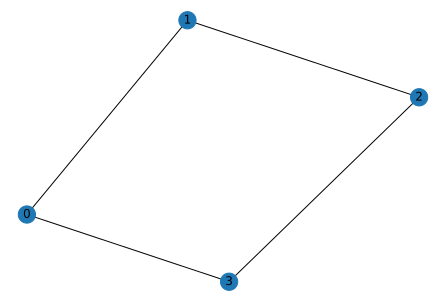

In [127]:

#Example:#
graph=[(0, 1,1.0), (0, 3,3.0), (1, 2,2.0), (2, 3,1.0)] 
nr_nodes=4

G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [128]:
#brut force  for verification :
def brut_MaxCut(graph,nr_nodes):
    
    W=np.zeros((int(nr_nodes),int(nr_nodes)))
    for i in graph:
        W[i[0]][i[1]]=i[2]
        W[i[1]][i[0]]=i[2]       


    best_cost_brute=0
    max_str=[]
    maxim=0
    for b in range(2**nr_nodes):
        x=[int(t) for t in reversed(list(bin(b)[2:].zfill(nr_nodes)))]
        cost=0
        for i in range(nr_nodes):
            for j in range(nr_nodes):
                cost=cost+W[i,j]*x[i]*(1-x[j])

        
        if best_cost_brute==cost:
            for i in range(len(x)):
                x[i]=str(x[i])
            max_str.append(''.join(x))
            
        if best_cost_brute<cost:
            best_cost_brute=cost
            max_str=[]
            for i in range(len(x)):
                x[i]=str(x[i])
            max_str.append(''.join(x))
 
            
    return  max_str, best_cost_brute
            
#Example:#      
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=7.0): 
 
1010
0101


 Now that we have a toy let's go back to Quantum stuff:

$$i\hbar\frac{d}{dt}|\Psi(t)>=H_C|\Psi(t)>=>|\Psi(t)>=e^{-iH_ct}|\Psi(0)>$$

Making the substitution : $U_C=e^{-iH_ct}$ =>$ |\Psi(t)>=U_C|\Psi(0)>$ .

Daca $U(t)$  e dependent de timp il putem impartii in bucatele mici ce par constante as Michael explain in his blog. Just thik about the erthsurface if we chooze a pice it seems flat but in reality it is curved.

$$ U(t,t_0)=U(t,t_{n-1})U(t_{n-1},t_{n-2})...U(t_1,t_0) $$

Alt truc matematic numit Troterization  enhance by the Teylor series :
    $$e^{A+B}=lim_{n->\infty}(e^{A/n+B/n})^n$$

But infintiy is a huge number so we will make onother aproximation and we will truncate the product and also in QAOA we can have different  $\gamma$ and $\beta$:
    

$$U_{QAOA}=e^{-iH_C\gamma_0+iH_B\beta_0}...e^{-iH_C\gamma_n-iH_B\beta_n}$$


Pentru simplitate o sa folosim mai departe : $U_C(\gamma_i)=e^{-iH_C\gamma_0} $ and $U_B(\beta_i)=e^{-iH_B\beta_0} $:


$$U_{QAOA}=U_C(\gamma_0)U_B(\beta_0)...U_C(\gamma_n)U_B(\beta_n)$$

Din cate am inteles in QAOA $\gamma$ and $\beta$ au rolul de a creea un salt asa ca incat chiar daca am redus numarul de straturi (de la infinit la 1 2 or 3 in some cases ) un fel de gradient exagerat. 
UB are rolul de a ne permine sa efectuam schimbari asupte unei stari daca cumva aceasta e un eiganvor  pentru $U_C(\gamma)$

## Bulding the Ansatz

$ U_B $ can be chosen by us and  in this example is a layer of prametrize $Rx(\beta)$ gate. Is it importhant that H_B doesn't comute with U_C.  It's time to decompose U_c in gates compatible with the hardware. Matrix form:

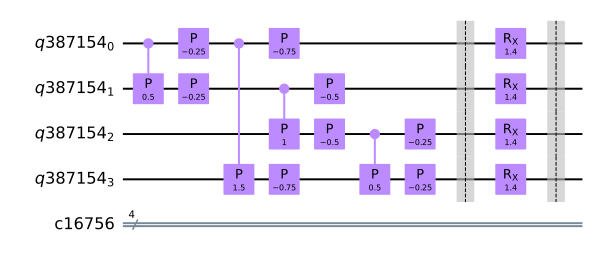

In [129]:
def UC_01(gamma,qc,qr,graph,nr_nodes):
    
    for edge in graph:
        qc.cp(gamma*float(edge[2]),qr[edge[0]],qr[edge[1]])
        qc.p(-gamma/2*float(edge[2]),qr[edge[0]])
        qc.p(-gamma/2*float(edge[2]),qr[edge[1]])
                
    qc.barrier()

def UB_01(beta,qc,qr):
    
    for i in range(len(qr)):
        qc.rx(2*beta,qr[i])
    qc.barrier()


#Example:#   
qr=QuantumRegister(nr_nodes)
cr=ClassicalRegister(nr_nodes)
qc=QuantumCircuit(qr,cr)

UC_01(0.5,qc,qr,graph,nr_nodes)
UB_01(0.7,qc,qr,)

qc.draw('mpl')

$U_B$ e simplu de realizat deoarece $H_B$ e ales de noi si trebuie doar sa tinem cont de fptul ca acesta nu comuta cu $H_C$ asa ca il putem alege tinanad cont de ce porti avem disponibile pe hardware . $U_C$ e dictat de priblema noastr si trbuie descompus in porti disponibile. In exemplul de fata:



$$U_C(\gamma)=e^{-iH_C\gamma}=e^{-i\gamma w_{ij}(Z_iZ_J)}$$



Example for 2  :

$$U_C(\gamma)= \begin{pmatrix}
                1 & 0 &0&0\\
                0 & e^{-i\gamma w_{ij}/2}&0&0\\
                0 & 0   &e^{-i\gamma w_{ij/2}}&0&\\
                0 & 0   & 0  &      1\\   
            \end{pmatrix}$$

Reproducerea lui $U_C$ cu porti hardware frendly:

$cp(-2a(p(a)p(a))=\begin{pmatrix}
                1 & 0 & 0 & 0 \\
                0 & 1 & 0 & 0 \\
                0 & 0 & 1 & 0 \\
                0 & 0 & 0 & e^{-2ia}\\
            \end{pmatrix}
            \begin{pmatrix}
                1 & 0 &0&0\\
                0 & e^{ia}&0&0\\
                0 & 0   &e^{ia}&0&\\
                0 & 0   & 0  &      e^{2ia}\\   
            \end{pmatrix} $

$$=\begin{pmatrix}
                1 & 0 &0&0\\
                0 & e^{ia}&0&0\\
                0 & 0   &e^{ia}&0&\\
                0 & 0   & 0  &      1\\   
            \end{pmatrix}$$

The last element but the first in our circuit is choosing an initial state , a  smart choice is a superposition of all the possible states. This is easy to achive with an H gate on each qubit 

In [130]:
def Init_H(qc,qr):
    for i in range(int(len(qr))):
        qc.h(qr[i])
    qc.barrier()

## Complete QAOA circuit 

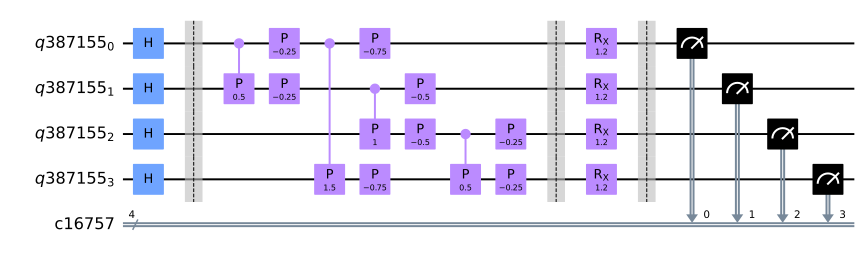

In [131]:
def QAOA_circ_01(graph,nr_nodes,params,l=1,measure=True):
    
    qr=QuantumRegister(nr_nodes)
    cr=ClassicalRegister(nr_nodes)
    qc_QAOA=QuantumCircuit(qr,cr)
    
    Init_H(qc_QAOA,qr)
    for i in range(l):
        UC_01(params[i*2],qc_QAOA,qr,graph,nr_nodes)
        UB_01(params[i*2+1],qc_QAOA,qr)
    
    if (measure==True):
        for i in range(nr_nodes):
            qc_QAOA.measure(qr[i],cr[i])
        return qc_QAOA
    return qc_QAOA

#Example:# 
QAOA_circ=QAOA_circ_01(graph,nr_nodes,[0.5,0.6],l=1)
QAOA_circ.draw('mpl') 

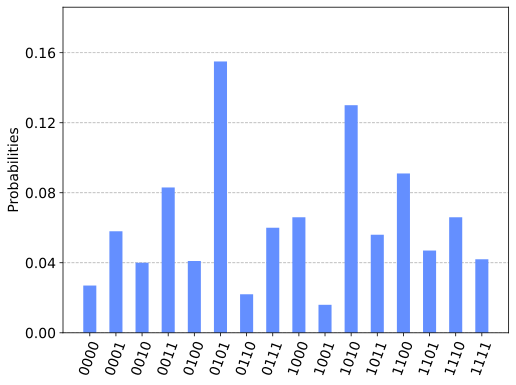

In [132]:
backend=Aer.get_backend("qasm_simulator")
shots=1000

simulate=execute(QAOA_circ, backend=backend, shots=shots)
counts=simulate.result().get_counts()
plot_histogram(counts,figsize = (8,6),bar_labels = False)

## Cost function

Now we need to evaluate the cost and minimize it. This can be achived in more ways:
- We can measure the  expected value of $< II..Z_i...Z_j...II>$ and add them to calcualte the expected value of $U_C$ (value).
- We can reduce the number of measurements (as executed circuits) by doing an experiment where we measure all qubits in $< Z >$ basis and from this point we can compute $< II..Z_i...Z_j...II>$ from counts for each element of $U_C$ or directly evaluate the cost (expected_01).


In [133]:
def expected_01(counts,graph,nr_nodes,shots):
    
    W=np.zeros((int(nr_nodes),int(nr_nodes)))
    for i in graph:
        W[i[0]][i[1]]=i[2]
        W[i[1]][i[0]]=i[2]
        
    cost=0
    for x in counts:
        for i in range (nr_nodes):
            for j in range(i+1,nr_nodes):
                if x[i]!=x[j]:
                    cost=cost-W[i][j]*counts[x]
    cost=cost/shots
    return cost

#Example:# 
cost=expected_01(counts,graph,nr_nodes,shots)
print(cost)

-4.493


Ca sa fac asta am sa folosesc o functie despre care am invatat in timpc ce ma pregateam pentru taskul de anul trcut. Pentru a calucula valoarea asteptata transforma mai intai portile Y, X in porti Z adaugant o rotatie suplimentara in circuit ( asta u e necesar aici deoarece hamiltoninul e ci=ompus doar dein combinati de Z si I ) iar dupa aceea efectueaza masuratorilie . De reparcat e ca caloarea valorii asteptate pentru toate elementele din paulis pot fii determinate cu un singur circui daca tinom cond unde avem I si pe ce qubit avem Z pentru a aplica -1 cand aceste e in strea 1 .  

Down I decompose $H_C$ in sum of pauli product and I will use it to  calculate expectation value:

In [134]:
I=np.array([[1,0],[0,1]],dtype=np.complex128)
X=np.array([[0,1],[1,0]],dtype=np.complex128)
Y=np.array([[0,-1.0j],[1.0j,0]],dtype=np.complex128)
Z=np.array([[1,0],[0,-1]],dtype=np.complex128)

pauli=[I,X,Y,Z]
labels=['I','X','Y','Z']

def decompose_H(graph,nr_nodes):  
    s=[]
    for i in range(nr_nodes):
        s.append('I')
    q=''
    for i in s:
        q=q+i
        
    pauli=[q]
    w=0
    for i in graph:
        w=w-i[2]/2
        
    weights=[w]
    for edge in graph:
        a=s.copy()
        a[edge[0]]='Z'
        a[edge[1]]='Z'
        eg=''
        for l in a:
            eg=eg+l
        pauli.append(eg)
        weights.append(edge[2]/2)
    return pauli, weights
paulis, weights=decompose_H(graph,nr_nodes) 

for i in range(len(pauli)):
    print("{}:{}".format(paulis[i],weights[i]))

IIII:-3.5
ZZII:0.5
ZIIZ:1.5
IZZI:1.0


In [135]:
def QAOA_cost_01(params,graph,nr_nodes,l=1,
              backend=Aer.get_backend("qasm_simulator"),shots=1000):
    
    qc_QAOA=QAOA_circ_01(graph,nr_nodes,params,l=l)
    counts=execute(qc_QAOA, backend=backend, shots=shots).result().get_counts()
    cost=expected_01(counts,graph,nr_nodes,shots)
    return cost

#Example:#
cost=QAOA_cost_01([0.5,0.6],graph,nr_nodes,l=1,
                backend=Aer.get_backend("qasm_simulator"),shots=1000)
print(cost)

-4.616


In [136]:
from tools import value

def QAOA_cost_02(params,graph,nr_nodes,backend,l=1,shots=5000):
    paulis, weights=decompose_H(graph,nr_nodes) 
    circ=QAOA_circ_01(graph,nr_nodes,params,l=l,measure=False)
    cost=value(weights,paulis,circ,backend,shots=shots)
    return cost

cost=QAOA_cost_02([0.5,0.6],graph,nr_nodes,backend,shots=5000)
print(cost)

-4.6302


QAOA solutions:
('0101', 2099)
('1010', 2093)

 Clasic solutions:
Best cut (cost=5.0): 
- 1010
- 0101

 Parameters: [1.31972438 0.53521398 1.56366767 0.33523948 0.75005401 0.20841197]
Quantum state cost -4.6092


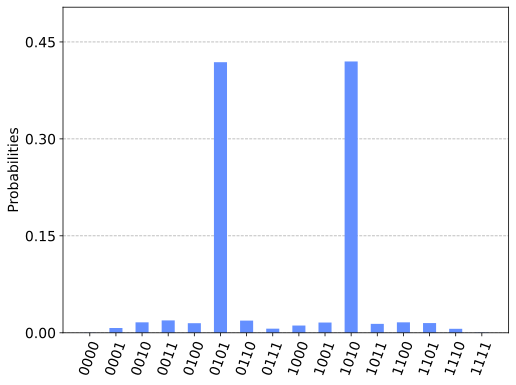

In [143]:
def MaxCut_01(graph,nr_nodes,l=1,params=[0.5,0.3],nr_s=2,shots=5000,method='COBYLA'):
    
    optim=minimize(QAOA_cost_01, 
                   params ,args=(graph,nr_nodes,l),method=method, 
                   options={'rhobeg': 1.0, 'maxiter': 2000, 
                            'disp': True, 'catol': 0.0002})
    QAOA_circ=QAOA_circ_01(graph,nr_nodes,optim.x,l=l)
    counts=execute(QAOA_circ, backend=backend, shots=shots).result().get_counts()
    counts=dict(reversed(sorted(counts.items(), key=lambda item: item[1])))
    
    o=0
    sol=[]
    for i in counts:
        sol.append((i[::-1],counts[i]))
        if len(sol)==nr_s:
            break
            
    return optim.x,counts,sol

#Example:#
para,counts, sol = MaxCut_01(graph,nr_nodes,params=[1.5,0.3,0.5,0.3,0.7,0.2],l=2,method='COBYLA')


print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,graph,nr_nodes,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)



Optimization terminated successfully    (Exit mode 0)
            Current function value: -4.482200000000001
            Iterations: 37
            Function evaluations: 630
            Gradient evaluations: 37
QAOA solutions:
('1100', 1334)
('0011', 1301)
('0101', 476)
('1010', 458)

 Clasic solutions:
Best cut (cost=7.0): 
- 1010
- 0101

 Parameters: [-20046525.98728788  -8698257.5507229     922749.39356751
  17223586.73170298  29099583.39280633 -31306525.24674161]
Quantum state cost -4.517


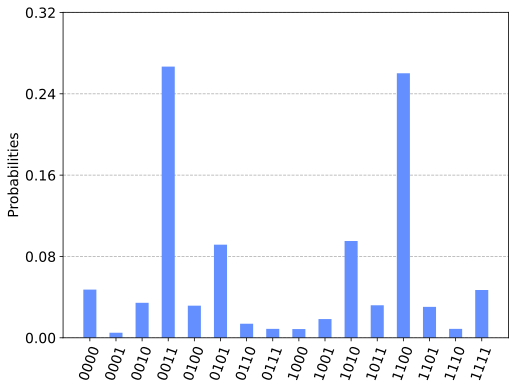

In [138]:
def MaxCut_02(graph,nr_nodes,l=1,params=[0.5,0.3],nr_s=2,shots=5000,method='COBYLA'):

    optim=minimize(QAOA_cost_02, 
                    params ,args=(graph,nr_nodes,backend,l,shots),
                    method=method, 
                    options={'rhobeg': 1.0, 'maxiter': 2000, 
                             'disp': True, 'catol': 0.0002})
    QAOA_circ=QAOA_circ_01(graph,nr_nodes,optim.x,l=l)
    counts=execute(QAOA_circ, backend=backend, shots=shots).result().get_counts()
    counts=dict(reversed(sorted(counts.items(), key=lambda item: item[1])))
    
    sol=[]
    for i in counts:
        sol.append((i[::-1],counts[i]))
        if len(sol)==nr_s:
            break
    return optim.x,counts,sol

para,counts, sol= MaxCut_02(graph,nr_nodes,params=[1.5,0.3,0.5,0.3,0.7,0.2],l=2,nr_s=4,method='SLSQP')

print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,graph,nr_nodes,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)




QAOA solutions:
('01001', 440)
('10110', 429)

 Clasic solutions:
Best cut (cost=24.0): 
- 00110
- 11001

 Parameters: [2.93489431 0.29108122 1.77628608 1.33327282 2.14678526 0.19772869]
Quantum state cost -17.1912


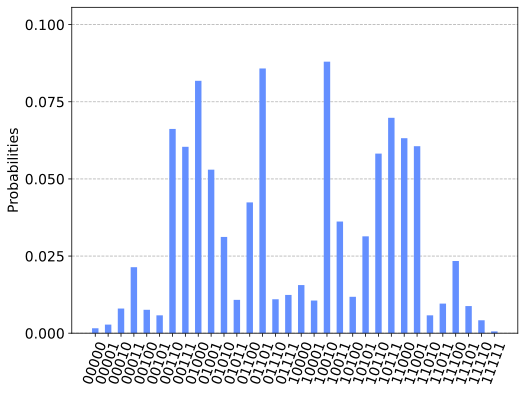

In [139]:
#Test2#

graph=[(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
nr_nodes=5

para,counts, sol = MaxCut_01(graph,nr_nodes,params=[1.900,0.2,1.900,0.2,1.900,0.2],l=3,method='COBYLA')


print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,graph,nr_nodes,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

QAOA solutions:
('100010', 486)
('011101', 389)

 Clasic solutions:
Best cut (cost=33.0): 
- 110010
- 001101

 Parameters: [1.92461028 0.43135112]
Quantum state cost -22.5886


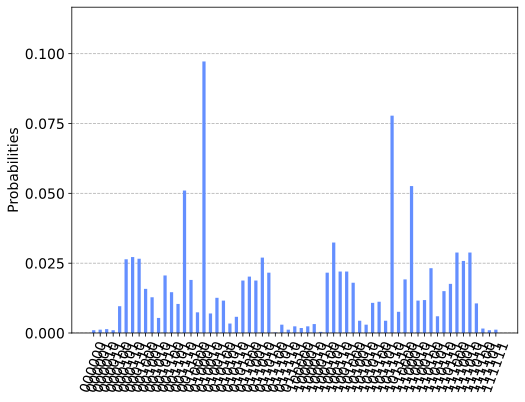

In [140]:
#Test3#

graph=[(5,0,9.0),(0,1,3.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]#[(0,1,1.0),(1,2,1.0),(2,3,1.0)]
nr_nodes=6

para,counts, sol = MaxCut_01(graph,nr_nodes,params=[1.900,0.2],l=1,method='COBYLA')


print("QAOA solutions:")
for i in sol:
    print(i)
    
print("\n Clasic solutions:")
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print("-",i)
    
print("\n Parameters:",para)  
print("Quantum state cost",expected_01(counts,graph,nr_nodes,shots=5000))
plot_histogram(counts,figsize = (8,6),bar_labels = False)

## Observation 

- Uneori algoritmul nu returneaza un graf maxim. O explicatie ar fii faptul ca noi nu ajungem defapt in minim datorita aproximatiei sau e poasibil sa ne blocam intr-un punct care e doar minim local sau sa ajungem pe un platou Barneau. E posibil ca in unele minime locale starea dominanta in care colapseza qubitul sa nu fie ce sa ne ofere maximum cut.(nu exclud nici posibilitatea de a realiza eu undeva o greasala )

- Deorece in cazul truc pentru a reduce numarin care nu coloram preferential nici un varf mereu o sa avem un nr par de solitii echivalente doua cate doua poate putem gazi un truc pentru a reduce nr de qubiti in viitor . La fel ca i cazul VQE pentru simetriile moleculare.

# Run result on a real device 

In [141]:
backend_hard=Aer.get_backend("qasm_simulator")

In [144]:
graph=[(0, 1,1.0), (0, 3,1.0), (1, 2,2.0), (2, 3,1.0)] 
nr_nodes=4

para,counts, sol = MaxCut_01(graph,nr_nodes,params=[-257.10383059,1736.12745091],l=1,method='COBYLA')

QAOA_circ=QAOA_circ_01(graph,nr_nodes,para,l=1)
counts=execute(QAOA_circ, backend=backend_hard, shots=shots).result().get_counts()
counts=dict(reversed(sorted(counts.items(), key=lambda item: item[1])))
print("\n Parameters:",para)
print ("Quantum sugestion:")
k=0;
for i in counts:
    print("{}:{}".format(i,counts[i]))
    k=k+1
    if k==4:
        break
        
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("\n Best cut (cost={}): ".format(best_cost))
for i in max_str:
    print(i)

ValueError: Unknown solver SR1

In [ ]:
# Resources:
#  https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained
#  https://qiskit.org/textbook/ch-applications/qaoa.html
#  https://lucaman99.github.io/new_blog/2020/mar16.html
#  https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html
# https://qiskit.org/documentation/_modules/qiskit/circuit/library/standard_gates/p.html
# https://qiskit.org/documentation/_modules/qiskit/circuit/library/standard_gates/rz.html#RZGate